In [1]:
#start all integration scripts like this

import sys
sys.path.append('/home/pwahle/Organoid-Image-Analysis/scripts/modules')
#alternative to sys.append('...'):
#set PYTHONPATH; in ~/.bashrc add below last line: export PYTHONPATH=/home/<your username>/Organoid-Image-Analysis/scripts/modules
#this option doesn't work for me.

import yaml 
import Paths #all kinds of paths, image paths are functions with default variables plate = "plate6", cycle = 'cycle1'; aligned_images_path has no variable 'cylce'. 


#load parameters
with open("../../params.yml", 'r') as ymlfile: 
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
    
globals().update(cfg) # optional, 'activates' all parameters

In [2]:
from skimage import io
from matplotlib import pyplot as plt
from skimage import filters
import os
import cv2 as cv
import numpy as np
import matplotlib
from skimage.filters import threshold_otsu
from skimage.filters import threshold_multiotsu
import copy
from skimage.feature import blob_log
import toolz
import imp
import imageio
import Example
imp.reload(Paths)


folder = Paths.aligned_images_path() + "/MAX_Time00000_Point0000_Point00{ii}_ChannelSCF_SD"



membrane = io.imread(folder + "/cycles/cycle1_aligned.tif")[...,1].astype('uint16')
dapi = io.imread(folder + "/cycles/cycle1_aligned.tif")[...,2].astype('uint16')

segmented_normal = io.imread(folder + "/dapi_mask.tif") # to generate this use Example.initial_segment(dapi = dapi, membrane = membrane)
segmented_log = io.imread(folder + "/dapi_mask_log_membrane.tif") #to generate this use Example.initial_segment(dapi = dapi, membrane = np.log(membrane))

subtracted = Example.subtract_membrane(dapi, membrane)

In [3]:
import generic_funcs
imp.reload(generic_funcs)

object_list = []
for i in [segmented_normal,segmented_log]:
     object_list.append(generic_funcs.get_nuclei_u_clusters_u_rpropstable_from_label_mask(i, subtracted))

In [4]:
for i in np.arange(0,2):
    object_list[i][0] = np.where(object_list[i][0]>0.5, 1000, 0)

union = object_list[0][0] + object_list[1][0]

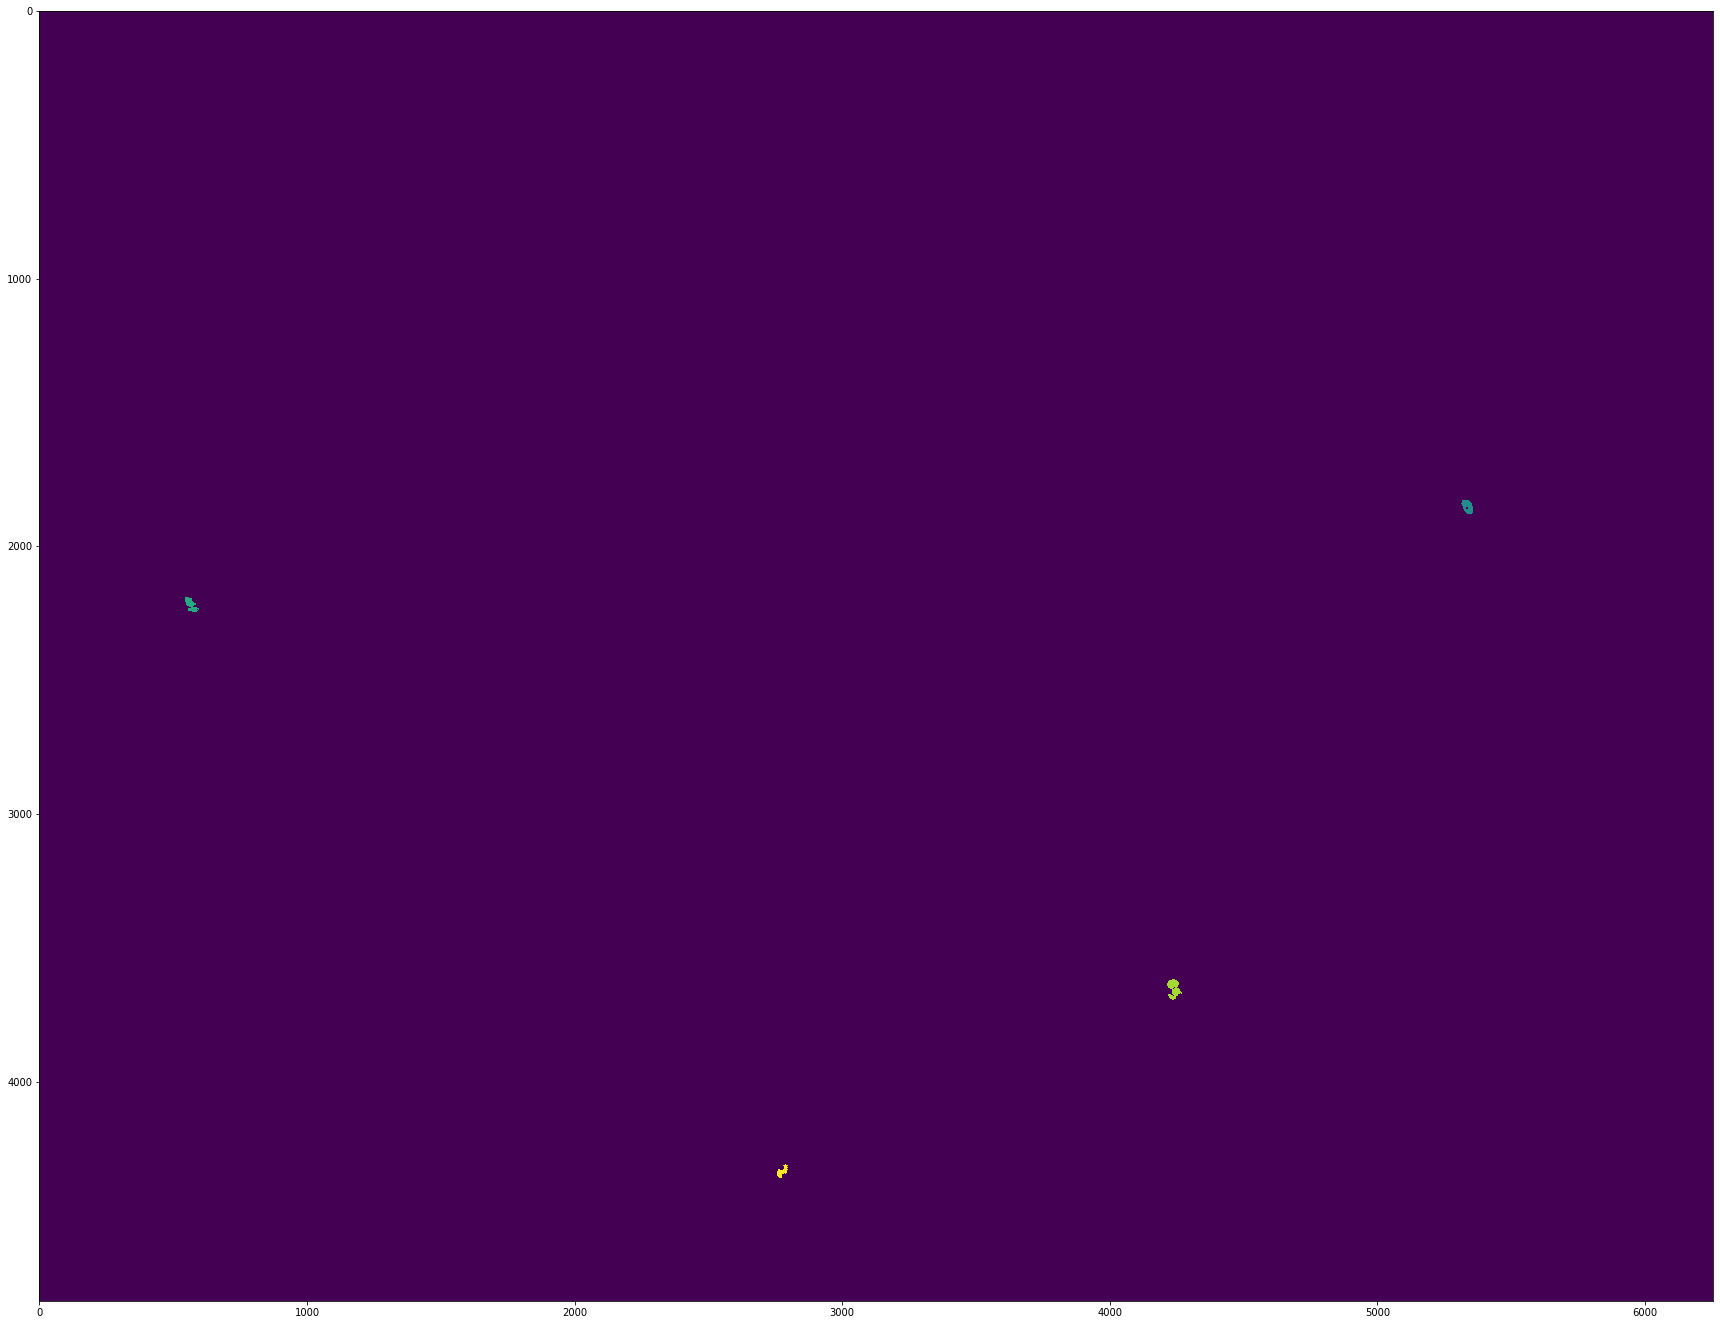

In [5]:
from skimage.measure import label
union = np.where(union>0.5, 1000, 0)

labeled_union = label(union, connectivity = 1)

union_object_list = generic_funcs.get_nuclei_u_clusters_u_rpropstable_from_label_mask(labeled_union, subtracted)

plt.figure(figsize = (30,30))
plt.imshow(union_object_list[1])
plt.show()

/home/pwahle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


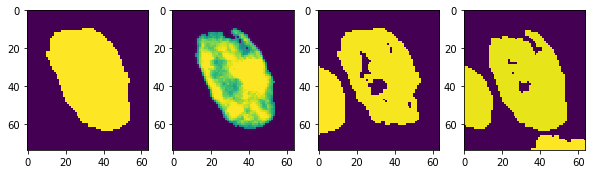

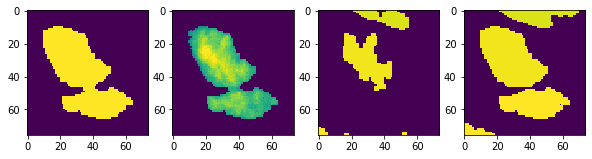

<Figure size 432x288 with 0 Axes>

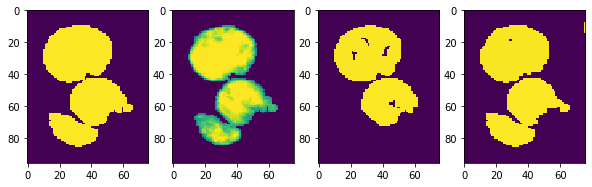

<Figure size 432x288 with 0 Axes>

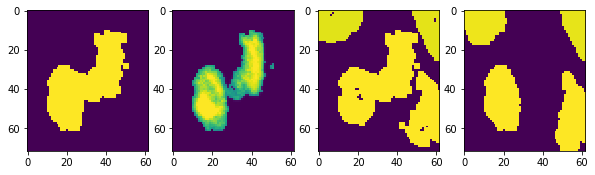

<Figure size 432x288 with 0 Axes>

'fig, ax = plt.subplots(1,2,figsize = (10,10))\nax[0].imshow(union_object_list[1][object_bboxes[1][0]:object_bboxes[1][2],object_bboxes[1][1]:object_bboxes[1][3]])\nax[1].imshow(subtracted[object_bboxes[1][0]:object_bboxes[1][2],object_bboxes[1][1]:object_bboxes[1][3]])\nplt.show'

In [6]:
from skimage.morphology import remove_small_holes

np.unique(union_object_list[1])

rprops_df = union_object_list[2]
object_bboxes = rprops_df.iloc[np.unique(union_object_list[1])[1:]-1][['bbox-0', 'bbox-1', 'bbox-2', 'bbox-3']].to_numpy()
solidities = rprops_df.iloc[np.unique(union_object_list[1])[1:]-1][['solidity']].to_numpy()



pair_mask = []
pair_dapi = []
segmented_bbox = []
segmented_log_bbox = []

for i in np.arange(object_bboxes.shape[0]):
        pair_mask.append(union_object_list[1][object_bboxes[i][0] - 10 :object_bboxes[i][2] + 10,object_bboxes[i][1] - 10 :object_bboxes[i][3] + 10 ])
        pair_dapi.append(subtracted[object_bboxes[i][0] - 10 :object_bboxes[i][2] +10 ,object_bboxes[i][1] - 10 :object_bboxes[i][3] + 10])
        segmented_bbox.append(segmented_normal[object_bboxes[i][0] - 10 :object_bboxes[i][2] + 10,object_bboxes[i][1] - 10 :object_bboxes[i][3] + 10 ])
        segmented_log_bbox.append(segmented_log[object_bboxes[i][0] - 10 :object_bboxes[i][2] + 10,object_bboxes[i][1] - 10 :object_bboxes[i][3] + 10 ])
        
        pair_mask[i] = remove_small_holes(pair_mask[i], area_threshold=30)
        pair_dapi[i] = filters.gaussian(pair_dapi[i], sigma=0.4, preserve_range=True, truncate = 3)
        pair_dapi[i][pair_mask[i] == 0] = 0
        


for i in np.arange(object_bboxes.shape[0]):
    fig, ax = plt.subplots(1,4,figsize = (10,10))
    ax[0].imshow(pair_mask[i])
    ax[1].imshow(pair_dapi[i])
    ax[2].imshow(segmented_bbox[i])
    ax[3].imshow(segmented_log_bbox[i])
    plt.figure(i+1)
    plt.show()

'''fig, ax = plt.subplots(1,2,figsize = (10,10))
ax[0].imshow(union_object_list[1][object_bboxes[1][0]:object_bboxes[1][2],object_bboxes[1][1]:object_bboxes[1][3]])
ax[1].imshow(subtracted[object_bboxes[1][0]:object_bboxes[1][2],object_bboxes[1][1]:object_bboxes[1][3]])
plt.show'''




In [7]:
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
from scipy import ndimage as ndi
from skimage.segmentation import watershed

labels = []
for i in np.arange(object_bboxes.shape[0]):
    if solidities[i] <= 0.9:
        distance_tmp = ndi.distance_transform_edt(pair_dapi[i])
        local_maxi_tmp = peak_local_max(distance_tmp, min_distance=25, indices=False,footprint=np.ones((20, 20)))
        markers_tmp = ndi.label(local_maxi_tmp)[0]
        labels.append(watershed(-pair_dapi[i], markers_tmp, mask=pair_mask[i] ,watershed_line = True))
        
    else:
        labels.append(pair_mask[i])
        

#pair1_dapi[pair1_mask == 0] = 0



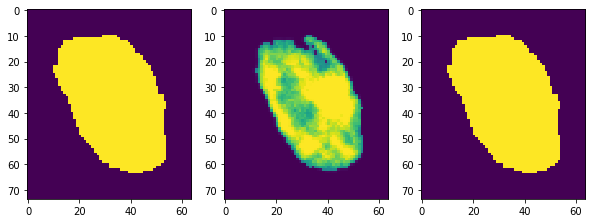

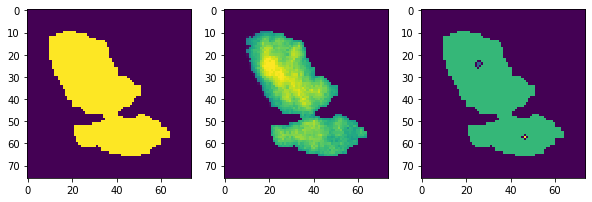

<Figure size 432x288 with 0 Axes>

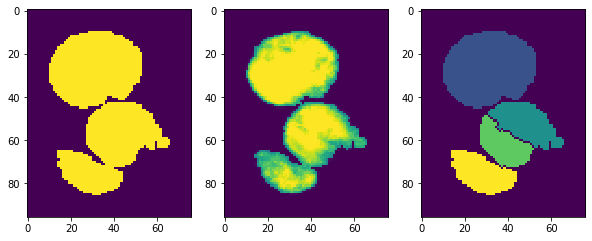

<Figure size 432x288 with 0 Axes>

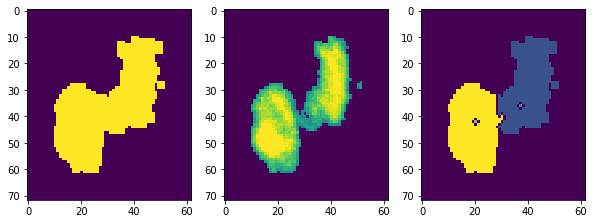

<Figure size 432x288 with 0 Axes>

'fig, ax = plt.subplots(1,3,figsize = (10,10))\nax[0].imshow(pair1_mask)\nax[1].imshow(pair1_dapi)\nax[2].imshow(labels)\nplt.show'

In [8]:
for i in np.arange(object_bboxes.shape[0]):
    fig, ax = plt.subplots(1,3,figsize = (10,10))
    ax[0].imshow(pair_mask[i])
    ax[1].imshow(pair_dapi[i])
    ax[2].imshow(labels[i])
    plt.figure(i+1)
    plt.show()


'''fig, ax = plt.subplots(1,3,figsize = (10,10))
ax[0].imshow(pair1_mask)
ax[1].imshow(pair1_dapi)
ax[2].imshow(labels)
plt.show'''

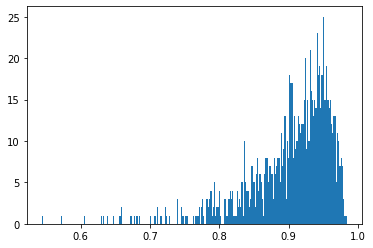

In [9]:
plt.hist(np.ravel(union_object_list[2]['solidity']),255)
plt.show()